## <center> Assignment 2: Counting Bloom Filters </center>

<center> Oscar Engelbrektson </center>
<center> CS110 Spring 2019 </center>

### Task 1: 
*Give an overview of the types of operations that a CBF supports, and give a few example applications that can benefit from using CBFs.*

Counting Bloom Filters are datastructures that allow set-membership-testing in a space (it does not actually store the values themselves, only an indicator for if they may have been inserted into the CBF) and time efficient manner. This comes at the expense of a risk for false-positives i.e. the CBF may indicate that an element is part of a set when in fact it is not. In other words, a CBF (with the exception of some deletion cases (see task 5)) can with certainty determine if an element is NOT in the CBF, it can however only show that an element is POSSIBLY in the CBF.

A Bloom Filter Consists of an array of length m, an empty CBF contains the value 0 at every index. Counting Bloom Filters support three operations: Inserting,Searching i.e. checking for set membership, and deleting. Ordinary Bloom Filters do not support deleting. 

In simple terms, the way inserting in a Counting Bloom Filter works is that it takes some input value and passes it through k hash functions, each of which return a numerical value between 0 and m-1. This numerical value corresponds to an index, which is incremented upwards by 1. This means that if several items have had a hash function map to the same index, the value at that index will be >1 (this is not possible in an ordinary hash table).

To search if a value is in the CBF, we pass the value through the k hash functions. If the value at every resulting index is non-zero, we conclude that the value is possibly in the CBF. If there is a zero at any of the indexes, we know for certain that the value has not been inserted previously.

To delete, we do the insert process in reverse. First we perform a search, to conclude that the element is possibly in the CBF. We then increment every index downwards by 1 (Wikipedia, 2019).

The situations, then, in which one would want to use a Counting Bloom Filter are those in which the inherent trade-offs of Bloom Filters - space and time efficiency at the cost of false-positives - are acceptable AND it is important to be able to delete values. Otherwise a normal Bloom Filter would suffice.
Two examples of when this might be the case:

First, it can be used for generating social security numbers - which, by design, are intended to be random-like so as to make guessing/stealing hard. In countries with large populations, millions - or in the case of India, over a billion - unique social security numbers need to be generated and stored. An efficient solution can be found in bloom filters if combined with a random number generator: whenever someone is born and needs a social security number, a random number can be generated and then checked if it is already in the bloom filter. If it is, then we can simply generate new numbers until we find one that is not taken - this is feasible as we can check set memberships in O(1) time using bloom filters. For this reason, false positives - we reject a number because we thought it was taken when it was actually free - are not a problem as we can simply try another number. It is important that we are able to delete social security numbers when their owners die, so as to prevent identity theft and other types of fraud (worth noting that some caveats need to be made to avoid false-negatives (see question 5)). Thus, Counting Bloom Filters could provide a viable solution to this task.

Secondly, ordinary bloom filters are commonly used in video recommendation engines, such as Youtube, to  keep track of which videos have already been viewed by a user, to prevent them from being recommended again (Derosiaux, 2017). This is a good application for a bloom filter because the service needs to be fast to create an frictionless user experience and false positives are acceptable: the worst that can happen is that a video that has not already been seen is not recommended - hardly the end of the world! However, if you are dealing with some learning based platform, like Khan Academy,  a user might need repeat previously covered content. As all Minervans know, spaced practice is one of the most effective learning techniques. To allow for an already seen video to be again placed in recommendation field, we would have to delete it from the bloom filter after some period of time - maybe one week, for instance. To do this, we would need a counting bloom filter.

### Task 2: 
*Implement your own CBF data structure and required hash functions using Python, justifying why you’ve chosen them.*

In [1]:
import mmh3

class counting_bloom_filter(object):
    
    #Initialize
    def __init__(self, size, k):
        
        #Size of filter
        self.size = size
        
        #Initializing table of length size filled with 0
        self.table = [0 for _ in range(size)]
        
        #Number of hash functions to be used
        #Initialize it because it must be remain constant for any table
        self.k = k
        
    #Add str for clarity
    def __str__(self):
        '''
        returns the hash table of the CBF
        '''
        return str(self.table)
    
    
    #Check if value in table.
    def search(self, value):
        '''
        If all indices are not 0, it is possibly in table
        Otherwise, we know it is not in table
        '''
                
        #If element possibly in table, return true
        #"possibly in" -> if all index are not 0
        
        
        index_list = [mmh3.hash(value, i)%self.size for i in range(self.k)]
        return all([self.table[index] is not 0 for index in index_list])
            
        
    #Insert value into table
    def insert(self, value):
        '''
        Compute k hashes corresponding to the value to be inserted
        modulo size to ensure each index in bounds
        Increment the value at each index by 1
        '''
        
        index_list = [mmh3.hash(value, i)%self.size for i in range(self.k)]
        for index in index_list:
            self.table[index] += 1
            
    
    #Insert value into table, if duplicates not okay
    def insert_restrictive(self, value):
        
        #List with all k indices, computed with hash functions
        #modulo size to ensure each index in bounds
        index_list = [mmh3.hash(value, i)%self.size for i in range(self.k)]
        
        #If element NOT in table, start insertion procedure
        #"not in" -> if any index is 0
        if any([self.table[index] is 0 for index in index_list]):
            
            #Increment every index up by 1
            for index in index_list:
                self.table[index] += 1
                
        #If value already in table, return error
        else:
            return print("Error: ", value, " already in table") 
    
            
    #Delete value from table
    def delete(self, value):
        '''
        If value is in table, increment indices down by 1
        Does not use search() to check if value is in table,
        as that would result in computing hash functions twice
        '''
        
        #List with all k indices
        #modulo size to ensure each index in bounds
        index_list = [mmh3.hash(value, i)%self.size for i in range(self.k)]
        
        #If element in table, start removal procedure
        #"in" -> if all index are not 0
        if all([self.table[index] is not 0 for index in index_list]):
            
            #Increment every index down by 1
            for index in index_list:
                self.table[index] -= 1
                
        #If value not in table, return error
        else:
            return print("Error: ", value, " not in table")    

**Hash Function Selection:**

When selecting hash function for a Bloom Filter, there are two main factors to consider: the uniformity of the distributions it produces conditional on the expected inputs, and the time it takes to compute the hash functions.
In this case, I will just be feeding it random strings so no hash functions optimized for sets of input will provide additional value. Example: if the expected inputs are usernames, "funguy" is more likely to be unput than "skdfsn" even though they have the same length. In this application, the two will be equally likely and thus an all-round hash function is desirable.

I choose to use murmurhash3 for 3 reasons. It provides one of the best tradeoffs between uniformity of distribution and computational complexity (Derosiaux, 2017); for that reason it is one of the most commonly used hash functions in real-world applications of Bloom Filters, another reason for why I wanted to learn how to use it; and lastly, it makes it easier to generalize the CBF to the use of k hash functions as the function mmh3.hash(value, i) I represents a seed which generates an independent hash function for every i.

## Task 3: 
*3. Using your own Python implementation and generating data to push into the CBF, provide an analysis, both theoretical and experimental, of how your implementation scales in terms of:*

## *a) memory size as a function of the false positive rate*

My implementation follows standard CBF procedures. Thus, under the assumption that the murmurhash3 hash functions provide close to a random uniform distribution of values, the mathematical formulas for CBF can be used to evaluate the theoretical my practical implementation.

The false positive rate f is a function of the number of hash functions k, the number of items stored n and the size of the memory m. Thus, to model m as a function of n, we have to fix k and the false positive rate f. The false positive rate f is given by (Wikipedia, 2019),

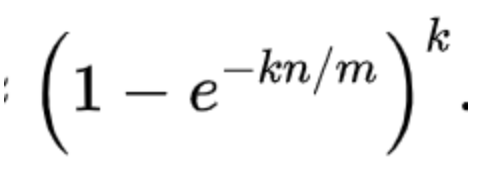

Fixing n = 100 and k=3 and solve for f as a function of m, subject to the constraint that m>0. We have that,

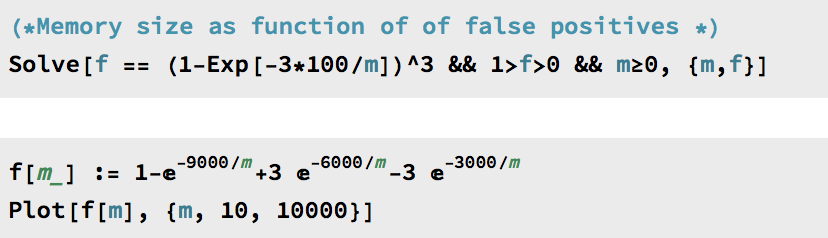

This function f(m) = 1-math.exp(-9000/m)+3*math.exp(-6000/m)-3*math.exp(-3000/m), will be our theoretical result to be compared to our empirical findings. (I will use Mathematica for algebraic manipulation, I hope that is OK).

In [2]:
#Importing libraries and functions needed

import random #for input generation
import matplotlib.pyplot as plt #for graphing
import string #for randomword
import math #for taking math.exp()

def randomword(): 
    
    '''
    Random word generator function from class. 
    Randomly generates words with length between 5 and 10
    '''
    
    return ''.join(random.choice(string.ascii_lowercase) for i in range(5))

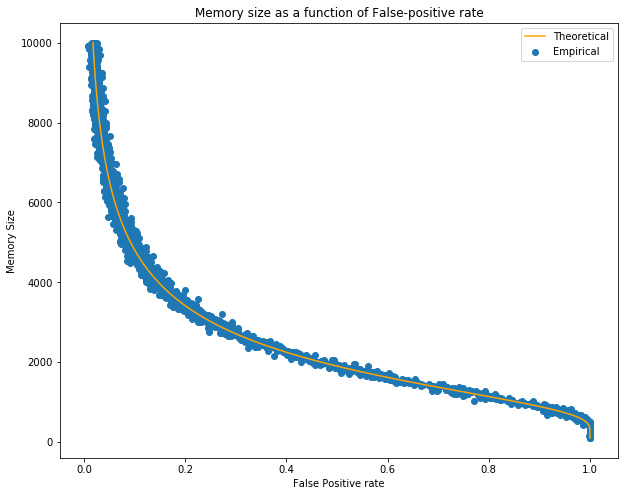

In [3]:
#memory size as a function of the false positive rate, 

#keeping number of hash functions k, and input size constant n
n = 1000
k = 3

#Initializing storage arrays
fp_rate = [] #False-positive rate

#Memory sizes between 10 and 1000, increments of 2
memory_size = [x for x in range(100, 10001, 5)] #Memory size

for size in memory_size:
        
    #create bloomfilter of size i, with k hash functions
    cbf = counting_bloom_filter(size, k)
    
    #generate test list
    test_list = [randomword() for _ in range(n)]

    #generate word list, with different words
    word_list = [randomword() for _ in range(n)]
    #Add words to bloom filter
    for word in word_list:
        cbf.insert(word)
    
    #initialize counters
    false_positive = 0
    true_negative = 0
        
    #for word in test_list
    for word in test_list:
        #if possibly word list
        if cbf.search(word) and word not in word_list:
                
                #increment true positive
                false_positive += 1
            
            #if possibly in wordlist, but not actually in
            #increment false_positive
        else:
            true_negative += 1
    
    #Update false positive rate storage
    #False positive rate = false positives/(true negatives + false positives)
    false_positive_rate = false_positive/(true_negative + false_positive)
    fp_rate.append(false_positive_rate)


#Theoretical results
#Based on function derived from above this code cell
theoretical_false_positive = [1-math.exp(-9000/m)+3*math.exp(-6000/m)-3*math.exp(-3000/m) for m in memory_size]

plt.figure(figsize=(10, 8))
plt.scatter(fp_rate, memory_size, label="Empirical")
plt.plot(theoretical_false_positive, memory_size, label="Theoretical", color="orange")
plt.title("Memory size as a function of False-positive rate")
plt.xlabel("False Positive rate")
plt.ylabel("Memory Size")
plt.legend(loc=0)
plt.show()

Because we are generating random input strings to our CBF, some noise is expected. As we can see, the empirical results align almost perfectly with the theoretical expectations. This should make us feel confident that the implementation of the CBF is correct.

Important note: as we see that the theoretical expectation essentially perfectly matches my practical implementation, we can be confident that the theoretical formula allows for valid inferences about my practical implementation of CBF and that the murmurhash3 functions provide an approximately random uniform distribution of values..  As it allows for exactly quanitfiable predictions, I will use this above qualitative evaluations of the code.

## *b) memory size as a function of the number of items stored*

Using the same relationship function as before: The false positive rate f is given by (Wikipedia, 2019),

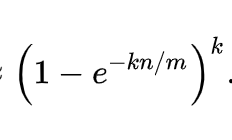

We fix k=3 and false positive rate f = 0.05 and solve for m, subject to the contraint that m nor n can be negative:

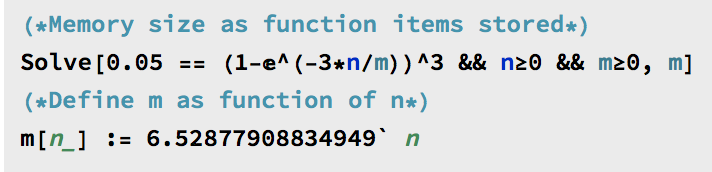

This function m(n) = 6.52877908834949n, will be our theoretical result to be compared to our empirical findings.

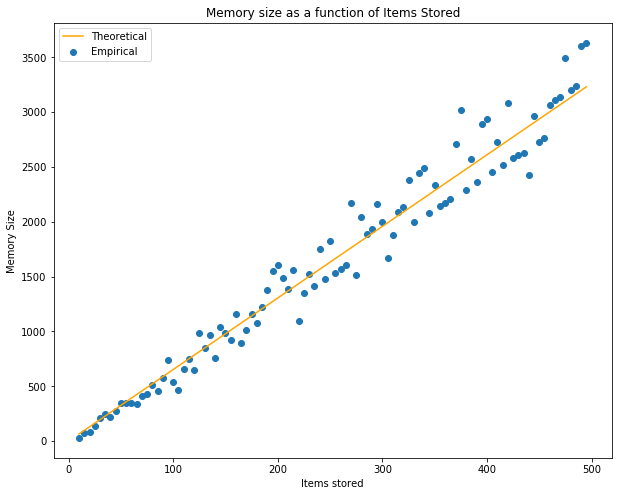

In [4]:
#Plotting memory size as a function of input size
import random
import string
import matplotlib.pyplot as plt

def randomword():
    return ''.join(random.choice(string.ascii_lowercase) for i in range(random.randint(5,10)))

#Fix false positive rate at 0.05
fixed_rate = 0.05 

#Initialize storage arrays
memory_size = [] 

#Varying items stored between 10 and 500, with increments of 5
input_size = [x for x in range(10, 500, 5)]

#For every step in input_size
for i in input_size:
    
    #initialize fp_rate at arbitrarily high number so it is larger than 0.05 first iteration
    fp_rate = 1
    
    #start with m = n, and go upwards from there
    current_memory = i
    
    #Incrementing current memory by 10%, until it reaches fixed_rate
    while fp_rate > fixed_rate:
        #Increase current memory by 10%
        current_memory = int(current_memory*1.1)
        
        '''
        The rest of the while loop is copied from a)
        see a) for comments
        '''
        cbf = counting_bloom_filter(current_memory, 3)
        
        word_list = [randomword() for _ in range(i)]
        for word in word_list:
                cbf.insert(word)
        
        test_list = [randomword() for _ in range(i)]

        false_positive = 0
        true_negative = 0
        for word in test_list:
            if cbf.search(word):
                if word not in word_list:
                    false_positive += 1
            else:
                true_negative += 1
        fp_rate = false_positive/(true_negative + false_positive)
    
    #append current memory size
    memory_size.append(current_memory)

#Theoretical memory size
theoretical_memory_size = [6.52877908834949*size for size in input_size]


plt.figure(figsize=(10, 8))
plt.scatter(input_size, memory_size, label="Empirical")
plt.plot(input_size, theoretical_memory_size, label = "Theoretical", color="orange")
plt.title("Memory size as a function of Items Stored")
plt.xlabel("Items stored")
plt.ylabel("Memory Size")
plt.legend(loc=0)
plt.show() 

Similar to our results in a):
Because we are generating random input strings to our CBF, some noise is expected. As we can see, the empirical results align almost perfectly with the theoretical expectations. This should make us feel even more confident that the implementation of the CBF is correct.

## *c) access time as a function of the false positive rate*

As seen before, the false positive rate is given by
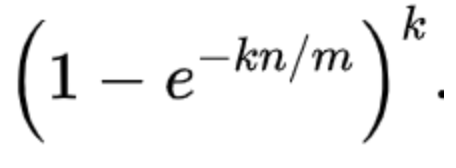

Thus, we can change the false positive rate by fixing two of variables and varying the third. In this task, I have made the arbitrary choice of fixing input size n and the number of hash functions k, whilst varying the size of the memory m.
For this task, 
n= 1000
k = 3

The time it takes to check for set membership using the search(value) function is proportional to the time it takes to compute the k=3 hash functions. We denote this time as O(k), where k represents the time to compute k hash functions. Crucially, this time O(k), is independent of whether the element is in the list or not - it is thus also independent of the false positive rate. If we were to model that way, then we would just have a straight line graph with value O(k).

Instead, I will implement an auxiliary search function, that is called ONLY IF search(value) returns that the value is possibly present. This will be an ordinary search to check list membership using the "[item] in [list]" syntax, which runs in O(n) time. This way, we would expect the expected access time to be a linear function of the false positive rate. This is true as the expected number of actual values in the CBF will remain constant as n=500 is fixed However, as the false positive rate increases will will be performing more, fruitless O(n)-time searches.

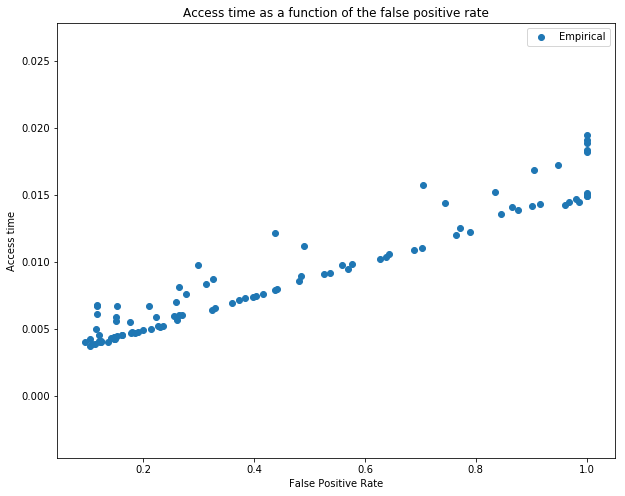

In [22]:
#c) access time as a function of the false positive rate
import random
import string
import matplotlib.pyplot as plt
import time #for time keeping

def randomword():
    return ''.join(random.choice(string.ascii_lowercase) for i in range(random.randint(5,10)))

fixed_rate = 0.05 #Fix false positive rate at 0.05
n = 1000 #fix input size at 1000
k = 3 #number of hash functions

#Varying memory between 100 and 5000, with increments of 50
memory_size = [x for x in range(100, 5000, 50)]

#Initializing storage arrays
access_time = []
fp_rate = []

for size in memory_size:
        
    #create bloomfilter of size i, with k hash functions
    cbf = counting_bloom_filter(size, k)
    
    #generate test list
    test_list = [randomword() for _ in range(n)]

    #generate word list, with different words
    word_list = [randomword() for _ in range(n)]
    #Add words to bloom filter
    for word in word_list:
        cbf.insert(word)
    
    #initialize counters
    false_positive = 0
    true_negative = 0
    
    #start timer at beginning of search
    start = time.time()
    
    #for word in test_list
    for word in test_list:
        #if possibly word list
        if cbf.search(word) and word not in word_list:
                
                #increment true positive
                false_positive += 1
            
            #if possibly in wordlist, but not actually in
            #increment false_positive
        else:
            true_negative += 1
    
    #end timer when search completed
    end = time.time()
    #Add access time to storage
    access_time.append(end-start)
    
    #Update false positive rate storage
    #False positive rate = false positives/(true negatives + false positives)
    false_positive_rate = false_positive/(true_negative + false_positive)
    fp_rate.append(false_positive_rate)



plt.figure(figsize=(10, 8))
plt.scatter(fp_rate, access_time, label="Empirical")
plt.title("Access time as a function of the false positive rate")
plt.xlabel("False Positive Rate")
plt.ylabel("Access time")
plt.legend(loc=0)
plt.show() 

As predicted in the the theoretical reasoning above the code cell, the access time is a linearly increasing function of the false positive rate.

If we were to just graph the time it takes to run search(value), we would have seen a constant access time with a value aproximately equalt to the y-intersect on this graph. We can infer this is the case because we know the time it takes to execute search(value) is independent of the false positive rate. The access time can thus be expressed as T(n) = O(n)*fp_rate + O(k), where O(k) is the constant time it takes to compute the k hash functions and O(n) is the time it takes to check list membership in a list of length n. Thus, when fp_rate = 0, which is represented by the y-intercept in the graph, T(n) = O(k).

## *d) access time as a function of the number of items stored*

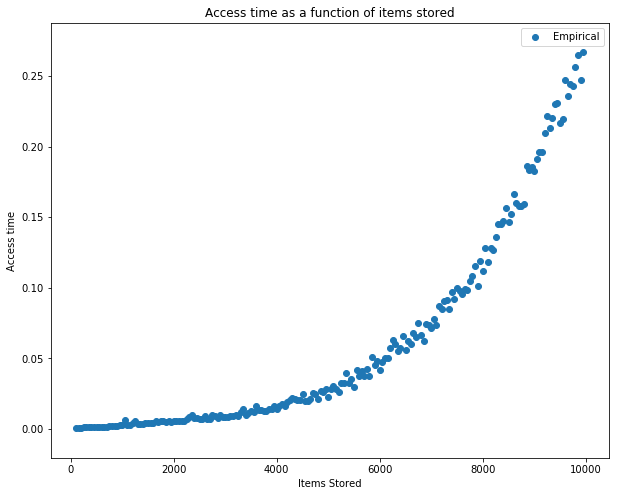

In [27]:
#d) access time as a function of the number of items stored
import random
import string
import matplotlib.pyplot as plt
import time #for time keeping

def randomword():
    return ''.join(random.choice(string.ascii_lowercase) for i in range(5))

fixed_rate = 0.1 #Fix false positive rate at 0.05
memory_size = 40000 #fix memory size
k = 3 #number of hash functions

#Varying memory between 100 and 5000, with increments of 50
input_size = [x for x in range(100, 10000, 50)]

#Initializing storage array
access_time = []

for i in input_size:
    
    #Continue until Break
    while True:
        #create bloomfilter of size i, with k hash functions
        cbf = counting_bloom_filter(memory_size, k)
    
        #generate test list
        test_list = [randomword() for _ in range(i)]

        #generate word list, with different words
        word_list = [randomword() for _ in range(i)]
        #Add words to bloom filter
        for word in word_list:
            cbf.insert(word)
    
        #start timer at beginning of search
        start = time.time()
    
        #for word in test_list
        for word in test_list:
            #if possibly word list
            if cbf.search(word) and word not in word_list:
                
                    #increment false_positive
                    false_positive += 1
            
            #if not wordlist, and correctly classified
            #increment true_negative
            else:
                true_negative += 1
    
        #end timer when search completed
        end = time.time()
    
        #False positive rate = false positives/(true negatives + false positives)
        false_positive_rate = false_positive/(true_negative + false_positive)
        
        #If within accepted false positive rate, append access time
        if false_positive_rate <= fixed_rate:
            access_time.append(end-start)
            
            #terminate loop, we have what we wanted.
            break



plt.figure(figsize=(10, 8))
plt.scatter(input_size, access_time, label="Empirical")
plt.title("Access time as a function of items stored")
plt.xlabel("Items Stored")
plt.ylabel("Access time")
plt.legend(loc=0)
plt.show()

In part c), we concluded that access time is a linear function of the false positive rate. The question of how the number of items stored affects the access time, then, boils down to how the number of items stored affects the false positive rate. Returning to the formula for the false positive rate,
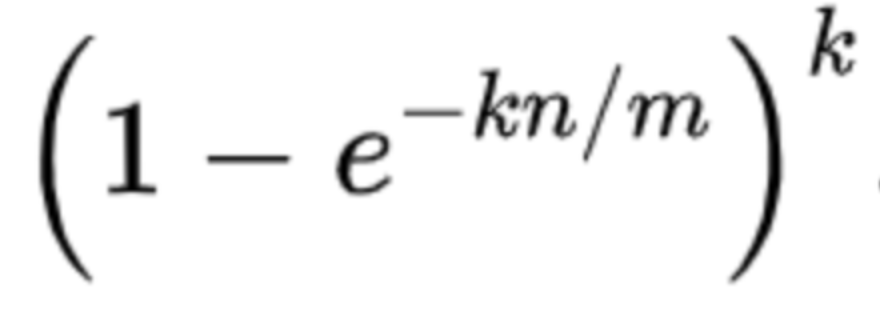

We then solve for the false positive rate f as a function of the items stored n, with m and k held constant.

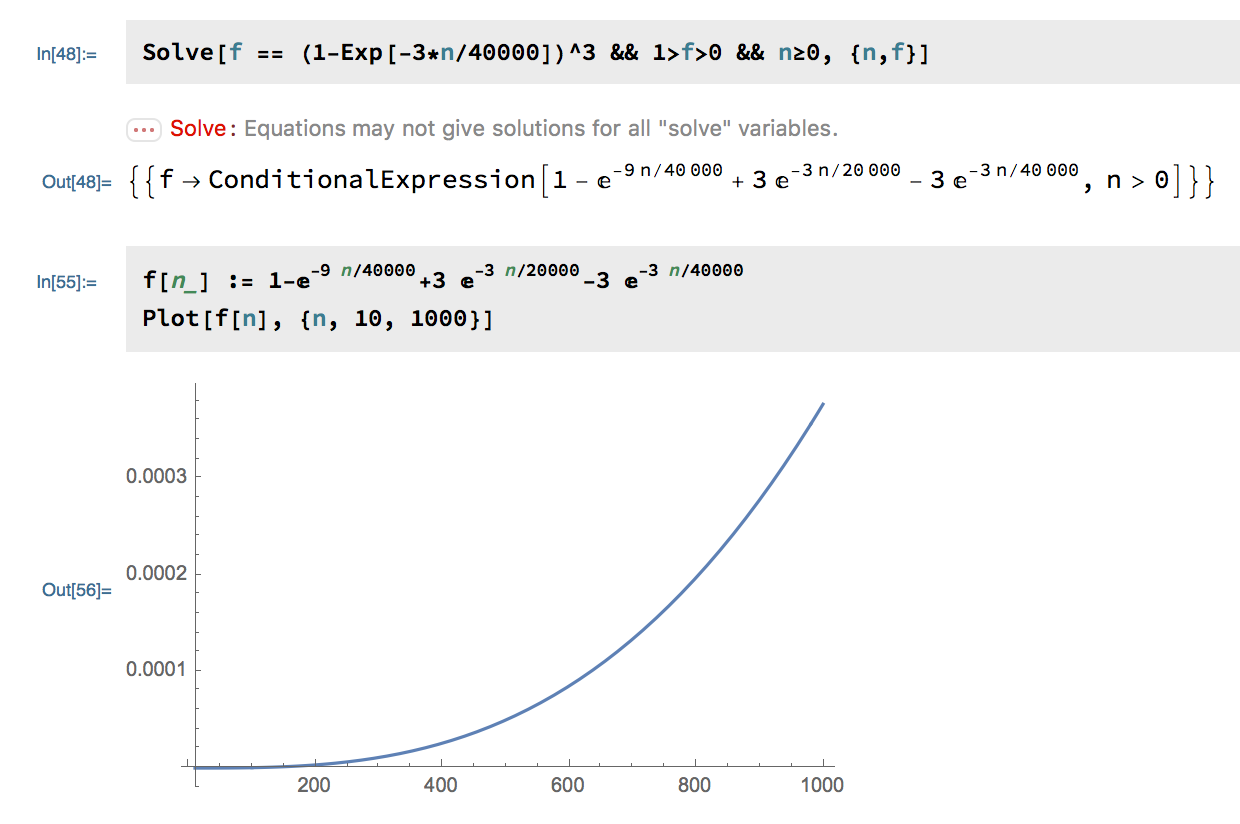

This gives a non-linear relationship, similar to the one found in the empirical results. Which, if multiplied by the linear relationship between false positive rate and access time, should be expected to give the exact same graph as above - to within practical runtime differences and stochastic variability. Thus, the empirical results align with our theoretical expectations.

### Task 4: 
*Produce a plot to show that your implementation’s false positive rate matches the theoretically expected rate.*

It turns out I already did this in task 3 a).

At this point, we know the function for the for the false positive rate as a function of m, n and k. For the same reasons as in 3c, we choose to fix n and k and m vary: "we can change the false positive rate by fixing two of variables and varying the third. In this task, I have made the arbitrary choice of fixing input size n and the number of hash functions k, whilst varying the size of the memory m."

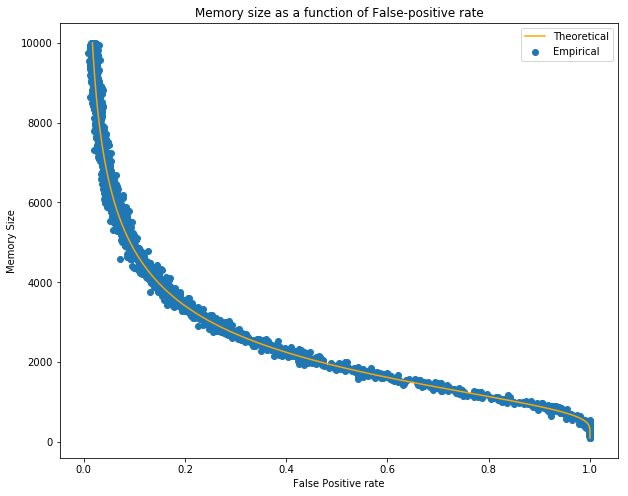

In [29]:
#This code is the same as in part 3. a)

#memory size as a function of the false positive rate, 

#keeping number of hash functions k, and input size constant n
n = 1000
k = 3

#Initializing storage arrays
fp_rate = [] #False-positive rate

#Memory sizes between 10 and 1000, increments of 2
memory_size = [x for x in range(100, 10001, 5)] #Memory size

for size in memory_size:
        
    #create bloomfilter of size i, with k hash functions
    cbf = counting_bloom_filter(size, k)
    
    #generate test list
    test_list = [randomword() for _ in range(n)]

    #generate word list, with different words
    word_list = [randomword() for _ in range(n)]
    #Add words to bloom filter
    for word in word_list:
        cbf.insert(word)
    
    #initialize counters
    false_positive = 0
    true_negative = 0
        
    #for word in test_list
    for word in test_list:
        #if possibly word list
        if cbf.search(word) and word not in word_list:
                
                #increment true positive
                false_positive += 1
            
            #if possibly in wordlist, but not actually in
            #increment false_positive
        else:
            true_negative += 1
    
    #Update false positive rate storage
    #False positive rate = false positives/(true negatives + false positives)
    false_positive_rate = false_positive/(true_negative + false_positive)
    fp_rate.append(false_positive_rate)


#Theoretical results
#Based on function derived from above this code cell
theoretical_false_positive = [1-math.exp(-9000/m)+3*math.exp(-6000/m)-3*math.exp(-3000/m) for m in memory_size]

plt.figure(figsize=(10, 8))
plt.scatter(fp_rate, memory_size, label="Empirical")
plt.plot(theoretical_false_positive, memory_size, label="Theoretical", color="orange")
plt.title("Memory size as a function of False-positive rate")
plt.xlabel("False Positive rate")
plt.ylabel("Memory Size")
plt.legend(loc=0)
plt.show()

### Task 5: 
*Enumerate (if any) corner cases that one might find in CBFs.*

#### *False negatives*

Using the delete function, it is possible to have false negatives. To illustrate, imagine we have a CBF with k=2, m=5 and n=3. The three values stored are "a", "b", and "c". There is then a special case where we can delete some vale that is not in the list, incrementing those indices down. Let's denote this "d". This may in turn lead to the CBF, claiming that c or d are not in the CBF. To illustrate how this would work, observe the below illustration,

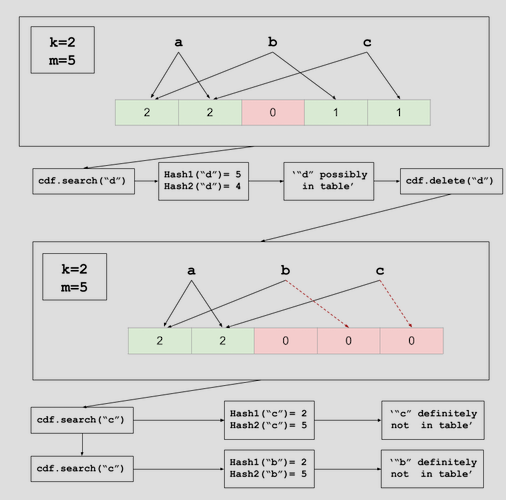

We see that "d" passes the search function as the value at index 4 and 5 is non-zero. This leads the CBF to allow the deletion, even though the element does not exist - a false positive. Having incremented them downwards, the value of index 4 and 5 is now 0. Thus, both "b" and "c" will now return "definitely not in table" as one of their corresponding indices has value 0 - a false negative. 

Depending on the application, this is potentially very disruptive. One way to avoid this corner case is to keep an auxiliary storage of all the words that have been inserted - this is commonly done anyways, often in an ordinary hash table. If the CBF search returns "possibly in", we then take the time to perform the O(n) search in this auxiliary storage ascertain whether it is definitely in, and thus avoid the possiblility of false negatives in the future. The benefit of the CBF in this case, is that you still save time not having to call the O(n) search in the cases where the element is "definitely not in".


##### *Non-string inputs.*

The counting bloom filter only accepts strings as input. Inputting a non-string will return an error.

##### *Improper n/m ratio*

If using the insert_restrictive(value) function, it is not possible to insert items once every index has a value >0. In the worst case, this can happen when nk = m - if the hash functions produce a perfectly uniform distribution. In the "best" case, it can happen when n = m. This happens when for every value, k-1 hash functions all map to some specific index i, and the remaining hash function maps to an a unique index with value 0.

### <center> Appendix A: HC Applications </center>

#audience: I try my best to write in such a way that it is comprehensible without prior knowledge of CBF's. That is, I avoid technical jargon, and when I do use technical jargon I explain what it means.

#dataviz: Throughout, I generate clear graphs following scientific conventions. I provide clear justification, through explanation and in-code comments for how the graph was generated. Furthermore, I interpret what conclusions can be drawn from each visualisation.

#algorithms: I am happy with my implementation of the counting_bloom_filters class. I have rewritten it several times and this is definitely the cleanest, most efficient iteration. Furthermore, it is generalizable to k hash functions. Throughout the assignment, code is clearly commented and follows principles of clarity.

#variables: This assignment involved quite a lot of variable manipulation for the theoretical part. And vairble incrementation for the empirical part. In both pracitcal and theoretical, itI try to make clear how each relates to the other. And why, in turn, what I am doing makes sense in terms of answering the current question in relation to CBF's.

#simulation. Throughout, particularly in Task 3 a)&b) and Task 4. I simulate the behavior of CBF's under different cirumstances to ascertain the relationship between input variables and characteristics such as access time. I clearly relate the simulation results to theoretical expectations. The simulations themselves are clearly explained, both in markdown and in in-code comments.

#organisation. The assignment is clearly structured and follows the desired organisational structure as outlined in the assignment intructions. This makes the assignment easy to follow along with. An a with-question basis, I make sure to explain how I will approach the task and why that makes theoretical sens, I then carry out my analysis and lastly I explain the results and how they relate to expectations.

### <center> References </center>

https://en.wikipedia.org/wiki/Bloom_filter#Counting_filters

Derisaux, S. (2017). The murmur3 hash function: hashtables, bloom filters, hyperloglog.
https://www.sderosiaux.com/articles/2017/08/26/the-murmur3-hash-function--hashtables-bloom-filters-hyperloglog/#other-hash-functions-and-benchmarks

Codebringer. (2016). An Introduction to Bloom Filter ( Probably Yes, Always No ). Youtube.
https://www.youtube.com/watch?v=x2sLjRK56YU&fbclid=IwAR3G1Yy4VNXkHx5N2HHiQt2rZzl5Keg7emaQ-ljlRGarcleYNYyBIXj2mKc